<a href="https://colab.research.google.com/github/prayan2702/Momentum-Screen/blob/main/N750_12M_First_rank_then_filter_Sharpe_MomoCode_V3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# V3.0 : Plot the results using matplotlib and added column  More than 50% up days in the last 12 months
# added line before downloading symbol data To resolve "cannot join tz-naive with tz-aware DatetimeIndex" error

"""
Created on Sun Aril 07 2024

@author: Rajesh Gavel
"""
#Date input from widget
End_date = "2024-10-24" #@param {type:"date"}

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

def getMedianVolume(data):
	return(round(data.median(),0))

def getDailyReturns(data):
	return(data.pct_change(fill_method = 'ffill')) #Modified

# change inf value to max and min value of that column
def getMaskDailyChange(data) :
 m1 = getDailyReturns(data).eq(np.inf) # for inf value
 m2 = getDailyReturns(data).eq(-np.inf) #for -inf value
 return(getDailyReturns(data).mask(m1, df[~m1].max(), axis=1).mask(m2, df[~m2].min(), axis=1).bfill(axis = 1))


def getStdev(data):
	return(np.std(getMaskDailyChange(data)*100))

def getStdRatio(data, data1):
	return((getStdev(data)/getStdev(data1)*100)) # to judge volatility 1 month against 1 year

def getAbsReturns(data):
	x = (data.iloc[-1]/data.iloc[0] - 1)*100
	return(round(x, 2))

def getVolatility(data):
	return(round(np.std(data) * np.sqrt(252) * 100, 2))

def getMonthlyPrices(data):
	grps = data.groupby([data.index.year, data.index.month])
	monthlyPrices = pd.DataFrame()
	for k in grps:
		monthlyPrices = pd.concat([monthlyPrices, k[1].tail(1)])
		# monthlyPrices = monthlyPrices.append(k[1].tail(1))
	return monthlyPrices

def getMonthlyReturns(data):
	return(data.pct_change())

def getSharpe(data):
	return(round(np.sqrt(252) * data.mean()/data.std(), 2))

def getSortino(data):
	return(np.sqrt(252) * data.mean()/data[data<0].std())

def getMaxDrawdown(data):
	cummRet = (data+1).cumprod()
	peak = cummRet.expanding(min_periods = 1).max()
	drawdown = (cummRet/peak) - 1
	return drawdown.min()

def getCalmar(data):
	return(data.mean()*252/abs(getMaxDrawdown(data)))

def getAbsMomentumVolAdjusted(absReturn, volatility):
	return(absReturn/volatility)

def getNMonthRoC(data, N):
	ret = round((data.iloc[-1]/data.iloc[-1-N] - 1) * 100, 2)
	return(ret)

def getNWeekRoC(data, N):
	ret = round((data.iloc[-1]/data.iloc[-1-N] - 1) * 100, 2)
	return(ret)

def getFIP(data):
	retPos = np.sum(data.pct_change()[1:] > 0)
	retNeg = np.sum(data.pct_change()[1:] < 0)
	return(retPos - retNeg)

def getSharpeRoC(roc, volatility):
	return(round(roc/volatility, 2))

#Beta should be calculated against relevant Index instead of Nifty50?
def getBeta(dfNifty, data12M):

	dailyReturns = getDailyReturns(pd.concat([dfNifty, data12M], axis = 1))[1:]

	var = np.var(dailyReturns['Nifty']) #Modified

	cov = dailyReturns.cov()

	cols = cov.columns[1:]

	beta = []

	for k in cols:
		beta.append(round(cov.loc[k, 'Nifty']/var, 2))

	return beta




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Universe:  N750
Lookback: 12 Months
Ranking: ['averageSharpe']
Filter: True


Start Date:  2000-01-01 00:00:00
12M Date:  2023-10-24 00:00:00
9M Date:  2024-01-24 00:00:00
6M Date:  2024-04-24 00:00:00
3M Date:  2024-07-24 00:00:00
1M Date: 2024-09-24 00:00:00
End Date:  2024-10-24 00:00:00


0,

50,

100,

150,

200,

250,

300,

350,

400,

450,

500,

550,

600,

650,

700,

Done with downloading DATA 

Got data slices for each timeframe 

Done calculating ROCs 

Done calculating Volatility 

Done calculating Sharpe  


 Writing unfiltered data to file. Shape in next line 

(750, 22)
Applied Filters 


 Writing data to file 


 Successfully Done 

Strategy: Buy top 30, hold till rank 75


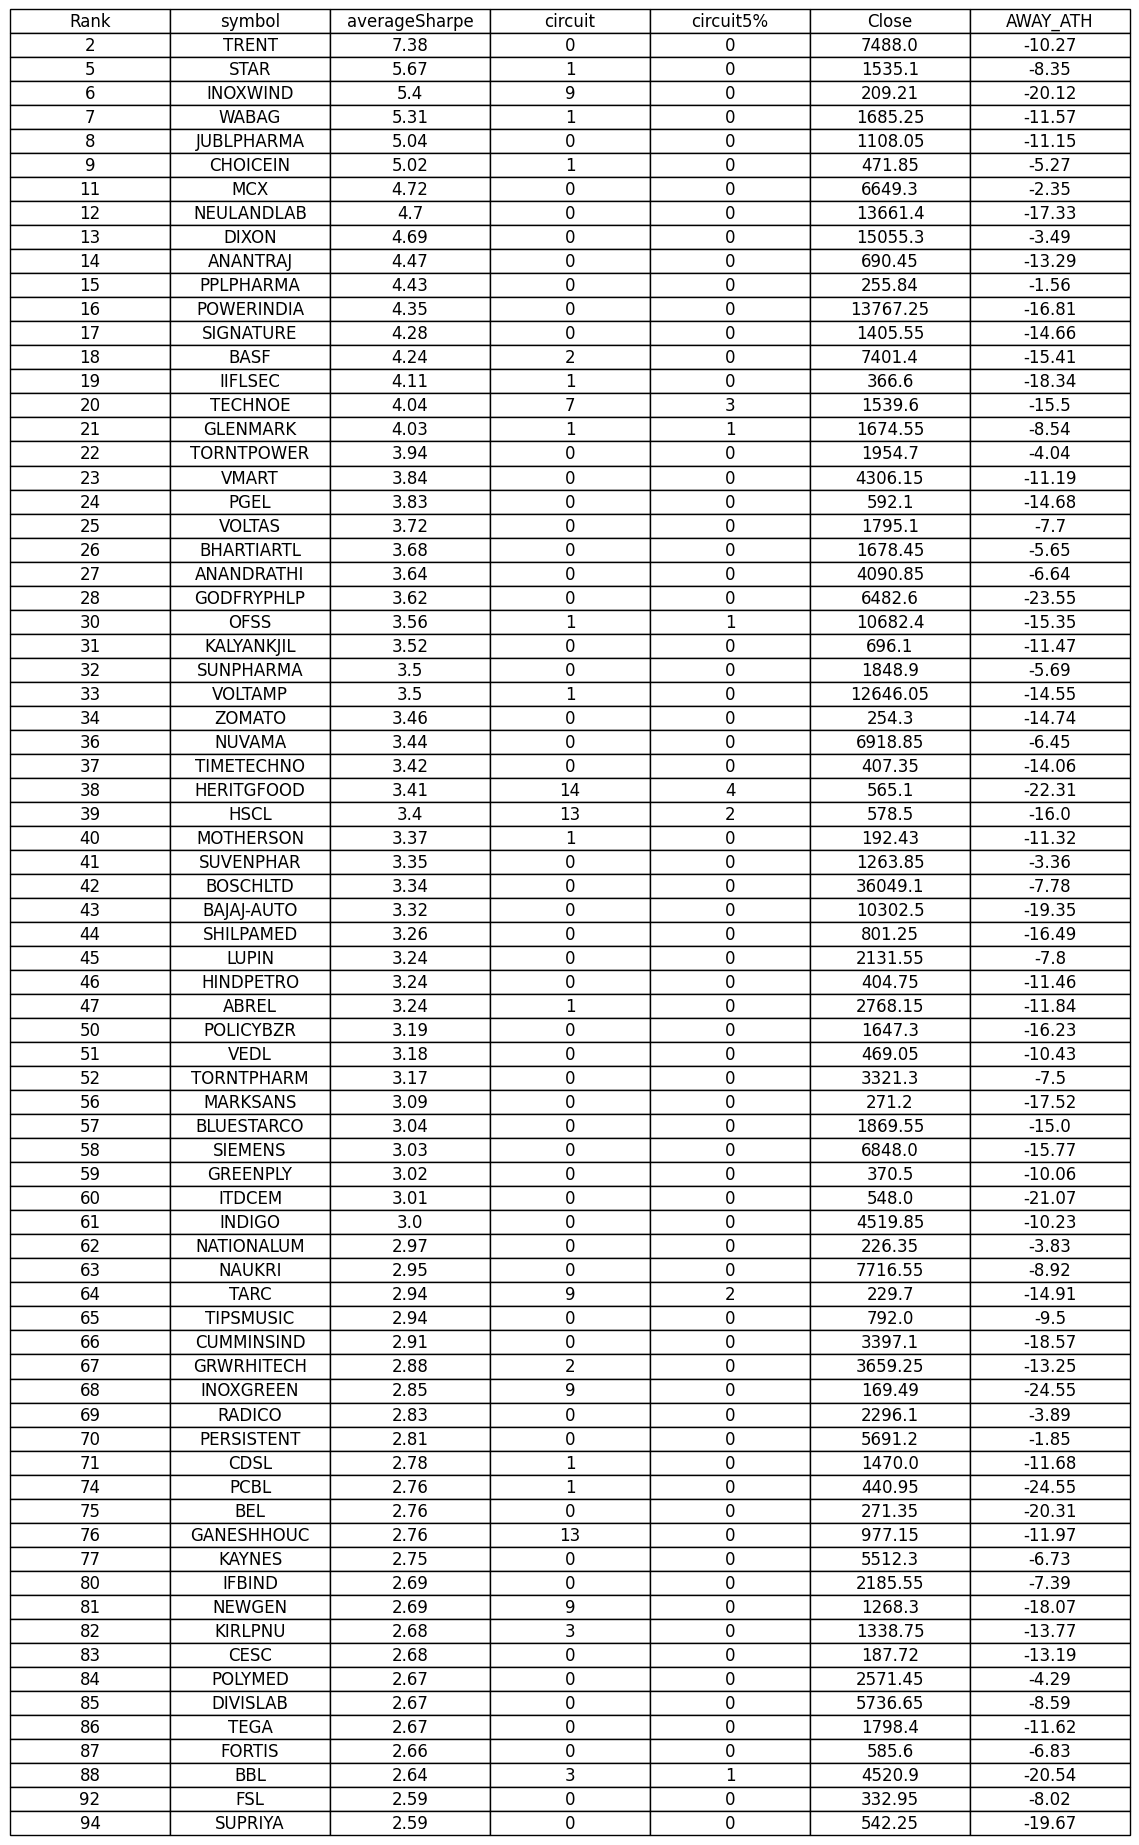

In [ ]:
import pandas as pd
import numpy as np
import time
from scipy.stats import zscore
from datetime import datetime
import yfinance as yf
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib.table import Table

#To suppress future warnings about using ffill method in pct_change()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_rows', 3000)
pd.set_option('display.width', 1000)

universe = ['Nifty50', 'Nifty100', 'Nifty200', 'Nifty250', 'Nifty500', 'N750', 'AllNSE']

# Pick universe, lookback
U = universe[5] #Selecting N750 Stocks

# Two-factor ranking
# First sort by Average sharpe of 12M, 9M, 6M and 3M and get the rank
# Next sort by deducting 1M ROC from 12M ROC to avoid recency bias and get the rank
# Add the above 2 ranks and sort by ascending ranks
#rm = ['sharpe12MRoC', 'FIP12M']
#rm = ['averageSharpe', '12MROCMinus1MROC']
rm = ['averageSharpe']

# Apply various filters
applyFilter = True

print('Universe: ', U)
print('Lookback: 12 Months')
print('Ranking:', rm)
print('Filter:', str(applyFilter))
print("\n")

# Dates: shift by 1 month at every rebalance
dates = dict()
# Don't change date below (20 year from today's date)
dates['startDate'] = datetime.strptime('2000-01-01', '%Y-%m-%d')
# change the end date below to today
dates['endDate'] = datetime.strptime(End_date , '%Y-%m-%d')
# calculating dates 1M back, 3M back, 6M back, 9M back and 12M back
dates['date1M'] = dates['endDate'] - relativedelta(months=+1)
dates['date3M'] = dates['endDate'] - relativedelta(months=+3)
dates['date6M'] = dates['endDate'] - relativedelta(months=+6)
dates['date9M'] = dates['endDate'] - relativedelta(months=+9)
dates['date12M'] = dates['endDate'] - relativedelta(months=+12)


#Print the dates
print('Start Date: ', dates['startDate'])
print('12M Date: ', dates['date12M'])
print('9M Date: ', dates['date9M'])
print('6M Date: ', dates['date6M'])
print('3M Date: ', dates['date3M'])
print('1M Date:', dates['date1M'])
print('End Date: ', dates['endDate'])
print('\n')

# Read index file
if U == 'Nifty50':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty50list.csv')
elif U == 'Nifty100':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty100list.csv')
elif U == 'Nifty200':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty200list.csv')
elif U == 'Nifty250':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_niftysmallcap250list.csv')
elif U == 'Nifty500':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty500list.csv')
elif U == 'N750':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_niftytotalmarket_list.csv')
elif U == 'AllNSE':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/NSE_EQ_ALL.csv')

# Drop unnecessary columns
df.drop(['Series', 'ISIN Code', 'Industry'], axis = 1, inplace = True)

# Create Yahoo symbol
df['Yahoo_Symbol'] = df.Symbol + '.NS'
df = df.set_index('Yahoo_Symbol')
symbol = list(df.index)


# Get yahoofinance data in chunks of 50
CHUNK = 50
close = []
high = [] #(Additional added condition)
volume = []
for k in range(0, len(symbol), CHUNK):
    print(k, end = ',', flush = True)
    print("\n")
    _symlist = symbol[k:k+CHUNK]
    _x = yf.download(_symlist, start = dates['startDate'], progress = False)
    _x = _x.tz_localize(None)    # To resolve "cannot join tz-naive with tz-aware DatetimeIndex" error
    close = _x['Close'] if len(close) == 0 else pd.concat([close, _x['Close']], axis = 1)
    high = _x['High'] if len(high) == 0 else pd.concat([high, _x['High']], axis = 1) #(Additional added condition)
    volume = _x['Close']*_x['Volume'] if len(volume) == 0 else pd.concat([volume, (_x['Close']*_x['Volume'])], axis = 1)
    time.sleep(.5)

print("Done with downloading DATA \n")
# Keep the data within the date range for 1 year and 10year(for ATH) data
data20Y = close[:dates['endDate']].copy()
volume20Y = volume[:dates['endDate']].copy() #(Additional added condition)
high20Y = high[:dates['endDate']].copy() #(Additional added condition)
volume12M = volume20Y[dates['date12M']:].copy() # Gets last 12M volume


# At least 12 months of trading is required
#data12M.dropna(axis = 1, inplace = True)
#volume12M.dropna(axis = 1, inplace = True)
data12M = data20Y[dates['date12M']:].copy() # Gets last 12M data
data9M = data20Y[dates['date9M']:].copy() # Gets last 9M data
data6M = data20Y[dates['date6M']:].copy() # Gets last 6M data
data3M = data20Y[dates['date3M']:].copy() # Gets last 3M data
data1M = data20Y[dates['date1M']:].copy() # Gets last 1M data

print("Got data slices for each timeframe \n")

# Stats DataFrame
dfStats = pd.DataFrame()

# Rate of change
dfStats['roc1M'] = getAbsReturns(data1M)
dfStats['roc3M'] = getAbsReturns(data3M)
dfStats['roc6M'] = getAbsReturns(data6M)
dfStats['roc9M'] = getAbsReturns(data9M)
dfStats['roc12M'] = getAbsReturns(data12M)


print("Done calculating ROCs \n")


# Volatility
dfStats['volatility3M'] = getVolatility(getDailyReturns(data3M))
dfStats['volatility6M'] = getVolatility(getDailyReturns(data6M))
dfStats['volatility9M'] = getVolatility(getDailyReturns(data9M))
dfStats['volatility12M'] = getVolatility(getDailyReturns(data12M))

print("Done calculating Volatility \n")

dfStats['sharpe12MRoC'] = getSharpeRoC(dfStats['roc12M'], dfStats['volatility12M'])
dfStats['sharpe9MRoC'] = getSharpeRoC(dfStats['roc9M'], dfStats['volatility9M'])
dfStats['sharpe6MRoC'] = getSharpeRoC(dfStats['roc6M'], dfStats['volatility6M'])
dfStats['sharpe3MRoC'] = getSharpeRoC(dfStats['roc3M'], dfStats['volatility3M'])

#MAIN FACTORS for ranking stocks. we are using 2 factors
dfStats['averageSharpe'] = dfStats["sharpe12MRoC"] #1st Factor
#dfStats['12MROCMinus1MROC'] = dfStats["roc12M"] - dfStats["roc1M"] #2nd Factor

print("Done calculating Sharpe  \n")

dfStats['volume'] = getMedianVolume(volume12M)


# Calculate No. of circuits in one year (Additional added condition)
dataDaily_pct = round(getDailyReturns(data12M)*100,2)
dfStats['circuit'] = (dataDaily_pct == 4.99).sum() + (dataDaily_pct == 5.00).sum() + (dataDaily_pct == 9.99).sum() + (dataDaily_pct == 10.00).sum() + (dataDaily_pct == 19.99).sum() + (dataDaily_pct == 20.00).sum() + (dataDaily_pct == -4.99).sum() + (dataDaily_pct == -5.00).sum() + (dataDaily_pct == -9.99).sum() + (dataDaily_pct == -10.00).sum() + (dataDaily_pct == -19.99).sum() + (dataDaily_pct == -20.00).sum()

#Calculate No. of 5% circuit in last 3-month for filter
dataDaily_pct5 = round(getDailyReturns(data3M)*100,2)
dfStats['circuit5%'] = (dataDaily_pct5 == 4.99).sum() + (dataDaily_pct5 == 5.00).sum() + (dataDaily_pct5 == -4.99).sum() + (dataDaily_pct5 == -5.00).sum()

# close and ema
dfStats['Close'] = round(data12M.iloc[-1], 2)

#Calculate ATH and Away from ATH% (Additional added condition)
dfStats['ATH'] = high20Y.max()
dfStats['AWAY_ATH'] = round((dfStats['Close']/dfStats['ATH']-1)*100,2) #Calculate %away from ALL TIME HIGH


#fileName = './OutputMonthly/RAW_' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.csv'
#data12M.to_csv(fileName, index = False, float_format = "%.2f")
data12M_Temp = data12M.fillna(0)     #(Modified as it inflated beta)
#dfStats['dma100d'] = round(data12M_Temp.rolling(window=100).mean().iloc[-1], 2)
dfStats['dma200d'] = round(data12M_Temp.rolling(window=200).mean().iloc[-1], 2)    #Modified

# More than 50% up days in the last 12 months
up_days = (data12M.pct_change() > 0).sum()
dfStats['up_days_pct'] = up_days / len(data12M) * 100

# Get Nifty data (Additional added condition)
# dfNifty = yf.download("^NSEI", start = dates['date12M'], end=dates['endDate'], progress = False)['Close']  #(Added enddate)
# dfNifty = dfNifty.to_frame().rename(columns = {'Close':'Nifty'})

# # Get stock beta (Additional added condition)
# dfStats['Beta'] = getBeta(dfNifty, data12M)

#PRINT OUT ALL THE STOCKS DATA without any filters
#print("\n Writing unfiltered data to file. Shape in next line \n")
#print(dfStats.shape)
#fileName = '/content/Unfiltered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.csv'
#unfiltered = dfStats.reset_index().rename(columns = {'index':'symbol'})
#unfiltered.to_csv(fileName, index = False, float_format = "%.2f")



#Ignore(drop) Top 10 percent Highest Beta stock against Nifty from the selected universe (Additional added condition)
#dfStats = dfStats.sort_values(by = ["Beta"], axis = 0, ascending=False)
#dfStats = dfStats.tail(len(dfStats) - round(len(dfStats)*0.1))     #drop top 10% highest beta

#FIRST, sort by Sharpe for 12M
unfiltered = dfStats.sort_values(rm[0], ascending = False).reset_index().rename(columns = {'index':'symbol'})
# Assign rank
unfiltered['Rank'] = range(1, unfiltered.shape[0] + 1)
unfiltered = unfiltered.sort_values('Rank', ascending = True)

# shift column 'Rank' to first position. First remove that column from list
first_column = unfiltered.pop('Rank')

# insert column using insert(position,column_name, first_column) function
unfiltered.insert(0, 'Rank', first_column)

# remove suffix:-'.NS' from symbol column
unfiltered.loc[:,('Ticker')] = unfiltered.loc[:,('Ticker')].str.replace('.NS', '')

#PRINT OUT ALL THE STOCKS DATA without any filters
print("\n Writing unfiltered data to file. Shape in next line \n")
print(dfStats.shape)
fileName = '/content/Unfiltered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.xlsx'
unfiltered.to_excel(fileName, index = False, float_format = "%.2f")


# Apply filters: e.g. RoC12M > FD rate
cond1 = unfiltered['volume'] > 10000000 #volume filter
#cond2 = unfiltered['Close'] > unfiltered['dma100d'] # above 100-day DMA
cond3 = unfiltered['Close'] > unfiltered['dma200d'] # above 200-day DMA
cond4 = unfiltered['roc12M'] > 6.5 #12M ROC above G-sec rate
cond5 = unfiltered['circuit'] < 20 #No. of circuit less than 20 (Additional added condition)
cond6 = unfiltered['AWAY_ATH'] > -25 #Away from All Time High within 25%
cond7 = unfiltered['roc12M'] < 1000  #12M return less than 10x and atleast 12M trading required
cond8 = unfiltered['roc1M']/unfiltered['roc12M']*100 < 50   #1m ROC/12m ROC < 50%
cond9 = unfiltered['Close'] > 30  #stock pricce above 30
cond10 = unfiltered['circuit5%'] <= 10   #No. of 5% circuit in last 3 month should be less than 6 (newly added)
#cond11 = unfiltered['up_days_pct'] > 50

cond = cond1 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9 & cond10

if applyFilter == True:
    filtered = unfiltered[cond]
elif applyFilter == False:
    filtered = unfiltered


print("Applied Filters \n")

#FIRST, sort by Sharpe for 12M
output = filtered.sort_values(rm[0], ascending = False)
# Assign rank
#output['Rank1'] = range(1, output.shape[0] + 1)

#SECOND, sort by (12M ROC - 1M ROC)
#output = output.sort_values(rm[1], ascending = False)
# Assign rank
#output['Rank2'] = range(1, output.shape[0] + 1)

#Now, combine both the ranks and sort with ranks sorted in ascending order
#output['FinalRank'] = output['Rank1'] + output['Rank2']
#output['FinalRank'] = output['Rank1']
output = output.sort_values('Rank', ascending = True)

# shift column 'Rank' to first position. First remove that column from list
first_column = output.pop('Rank')

# insert column using insert(position,column_name, first_column) function
output.insert(0, 'Rank', first_column)

print("\n Writing data to file \n")

fileName = '/content/Filtered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.xlsx'
output.to_excel(fileName, index = False, float_format = "%.2f")
print("\n Successfully Done \n")

#(Additional Print)
# Pick stocks


print("Strategy: Buy top 30, hold till rank 75")

# Sort by final rank and get top 75
df_sorted = output.sort_values('Rank').head(75)

# # Separate top 30 and next 45
top_30 = df_sorted.head(30)
next_45 = df_sorted.iloc[30:75]

# Prepare table data
tbl_data = []
for i, row in df_sorted.iterrows():
    tbl_data.append([ row['Rank'],row['Ticker'],
                     row['averageSharpe'], row['circuit'],
                     row['circuit5%'], row['Close'],
                     row['AWAY_ATH']])

# Plot the results using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Create a table
col_labels = ['Rank', 'symbol', 'averageSharpe', 'circuit', 'circuit5%', 'Close', 'AWAY_ATH']
table = ax.table(cellText=tbl_data, colLabels=col_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# # Draw a red line to separate the top 30
# for i in range(len(col_labels)):
#     cell = table[(30, i)]
#     cell.set_edgecolor('red')
#     cell.set_linewidth(3)

# Adjust layout
plt.subplots_adjust(left=0.1, top=0.85)  # Adjust top parameter for title position
#plt.title('Top 75 Stocks Momentum Ranking', fontsize=18, y=1.05)  # y parameter for title position
plt.show()

